In [1]:
import pandas as pd
import numpy as np
import sklearn
from scipy.stats import skew, kurtosis
from scipy.stats import describe
from scipy.stats.mstats import gmean
import matplotlib.pyplot as plt
import scipy.linalg
import pprint as pprint
import time as time
from sklearn.decomposition import PCA

In [ ]:
# Problem 1

#if x and y is normal, can just use multivariate normal, y = f(X, epsilon)


#matrix of [X E] ~ N(u,E)
#X ~ N(u, E)
#E ~ N(0, I)
#y = f(X, epsilon)
#epsilon ~ N(0, I)

#matrix = Sigma

#[x epsilon] ~ (u,sigma)   where u = [x1 zero]

#y = f(x, epsilon)   observed x and epsilon which is error term to get y  There is a beta value there usually

,x
0,-0.002665
1,-0.045128
2,0.053635
3,0.010450
4,-0.016284


VaR: 8.1255
ES: 11.1715


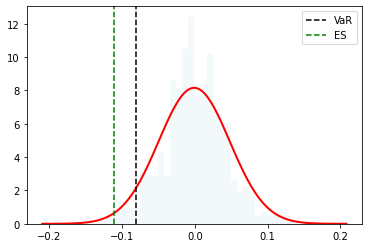

In [39]:

from scipy.stats import norm
from scipy.stats import rv_continuous
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Read in the CSV file with pandas
data = pd.read_csv('problem1.csv')

#convert to numpy array
data = data.to_numpy()

def fit_normal(x):
    # Mean and Std values
    m = np.mean(x)
    s = np.std(x)
    
    # Create the error model
    error_model = norm(m, s)
    
    # Calculate the errors and U
    errors = x - m
    u = error_model.cdf(x)
    
    # Define the evaluation function
    def eval_func(u):
        return error_model.ppf(u)
    
    # Return the fitted model
    return {"errors": errors, "u": u, "eval": eval_func, "model": error_model}


NormDistFitted = fit_normal(data)

num_simulations = 1000
simulated_value = NormDistFitted['model'].rvs(num_simulations)

# Calculate VaR
alpha = 0.05 
var = -NormDistFitted['model'].ppf(alpha)
pdf = NormDistFitted['model'].pdf

# Calculate Expected Shortfall

def ES_func(x):
    return x * pdf(x)

ES, _ = quad(ES_func, -np.inf, var)
ES = -ES / alpha

# Print the results
print('VaR: {:.4f}'.format(var*100))
print('ES: {:.4f}'.format(ES*100))

# Plot the histogram of the data
plt.hist(data, bins=50, density=True, alpha=0.05)

# Plot the fitted PDF
x = np.linspace(np.min(data), np.max(data), 100)
y = NormDistFitted['model'].pdf(x)
plt.plot(x, y, 'r-', lw=2)

# Plot VaR and Expected Shortfall lines
plt.axvline(-var, color='black', linestyle='--', label='VaR')
plt.axvline(-ES, color='green', linestyle='--', label='ES')

plt.legend()
plt.show()



VaR: 7.6476
ES: 11.4446


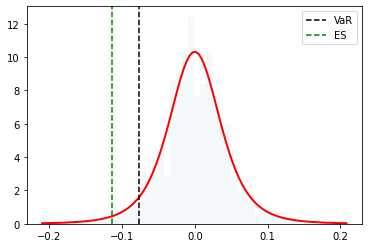

In [53]:
from scipy.stats import t
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize

import numpy as np
from scipy.stats import t as t_dist
from scipy.optimize import minimize

data = pd.read_csv('problem1.csv')

#convert to numpy array
data = data.to_numpy()


def general_t_ll(mu, s, nu, x):
    td = t_dist(nu)
    log_pdf = td.logpdf((x - mu) / s) - np.log(s)
    return -np.sum(log_pdf)

def fit_general_t(x):
    # Approximate values based on moments
    start_m = np.mean(x)
    start_nu = 6.0 / stats.kurtosis(x) + 4
    start_s = np.sqrt(np.var(x) * (start_nu - 2) / start_nu)

    def _gtl(theta):
        return general_t_ll(*theta, x)

    bounds = ((None, None), (1e-6, None), (2.0001, None))
    result = minimize(_gtl, (start_m, start_s, start_nu), bounds=bounds)

    m, s, nu = result.x
    t_dist_fitted = t_dist(nu, loc=m, scale=s)
    return {'m': m, 's': s, 'nu': nu, 'model': t_dist_fitted}


TDistFitted = fit_general_t(data)

num_simulations = 1000
simulated_value = TDistFitted['model'].rvs(num_simulations)

# Calculate VaR
alpha = 0.05 
var = -TDistFitted['model'].ppf(alpha)
pdf = TDistFitted['model'].pdf

# Calculate Expected Shortfall
def ES_func(x):
    return x * pdf(x)

ES, _ = quad(ES_func, -np.inf, var)
ES = -ES / alpha

# Print the results
print('VaR: {:.4f}'.format(var*100))
print('ES: {:.4f}'.format(ES*100))

# Plot the histogram of the data
plt.hist(data, bins=50, density=True, alpha=0.05)

# Plot the fitted PDF
x = np.linspace(np.min(data), np.max(data), 100)
y = TDistFitted['model'].pdf(x)
plt.plot(x, y, 'r-', lw=2)

# Plot VaR and Expected Shortfall lines
plt.axvline(-var, color='black', linestyle='--', label='VaR')
plt.axvline(-ES, color='green', linestyle='--', label='ES')

plt.legend()
plt.show()
